# ⚖️ Supervised Contrastive Learning vs. Softmax Classification

This notebook demonstrates and compares two approaches to supervised classification:

1. **Standard Softmax Classification** using cross-entropy loss  
2. **Supervised Contrastive Learning (SupCon)** followed by a linear classifier

---

## 🎯 Key Objectives:

### 1. Implement **Supervised Contrastive Loss**
- Encourages samples from the same class to have **closer embeddings**
- Separates embeddings of different classes
- Trained on a backbone encoder + SupCon loss

### 2. Compare with **Standard Softmax Classifier**
- Uses softmax layer with cross-entropy loss directly on top of encoder
- Common baseline for classification tasks

### 3. Visualize and Evaluate:
- Use **t-SNE or PCA** to project embeddings into 2D
- Evaluate:
  - Accuracy
  - Precision/Recall
  - Embedding structure and separation

---

## 🧠 Why Supervised Contrastive Learning?

- Encourages **more discriminative feature representations**
- Often **more robust to overfitting**, especially with limited data
- Can outperform softmax on **few-shot** or **noisy-label** tasks

✅ By the end of this notebook, you'll understand how **representation learning with contrastive loss** can improve downstream classification performance.

## 📦 Import Required Libraries

We'll import all necessary libraries for model development, training, and visualization.

### 🔧 Core Libraries:
- **TensorFlow** – For building and training the neural network models
- **NumPy** – For numerical operations and array manipulation
- **Matplotlib** – For plotting loss, accuracy, and embedding visualizations
- **scikit-learn (sklearn)** – For evaluation metrics and t-SNE dimensionality reduction

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import keras
from keras import layers

## 🧹 Data Preparation

We’ll use the **CIFAR-10** dataset for this experiment, as it provides a good benchmark for visual classification tasks.

### 🛠️ Steps:
1. **Load CIFAR-10** from `tf.keras.datasets`
2. **Normalize** pixel values to `[0, 1]`
3. **Apply data augmentation** to improve generalization:
   - Random horizontal flip
   - Random rotation
   - Random zoom

In [2]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


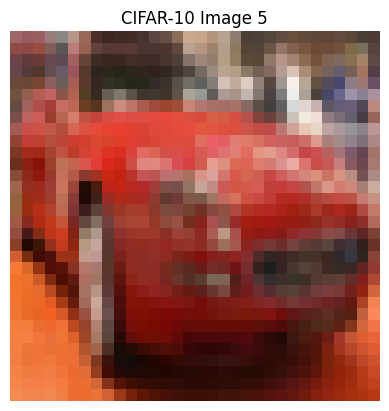

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train is loaded as in your provided code
# If x_train is not available in this context, replace this with a sample image:
# For Example:
# x_train = np.random.rand(32, 32, 3)  # Create a random image

# Reshape if needed, e.g., if x_train is a 4D array:
if len(x_train.shape) == 4:
    image_index = 5  # Choose an image to display
    image_to_display = x_train[image_index]

    # Display the image
    plt.imshow(image_to_display)
    plt.axis('off')  # Hide axes
    plt.title(f"CIFAR-10 Image {image_index}")
    plt.show()
elif len(x_train.shape) == 3:
    plt.imshow(x_train)
    plt.axis('off')
    plt.title("Image")
    plt.show()

else:
  print("x_train shape is not 3 or 4. Cannot display image.")


## 🧠 Supervised Contrastive Loss Implementation

The **Supervised Contrastive Loss (SupCon)** encourages the model to learn **discriminative embeddings** by pulling together samples of the same class and pushing apart samples of different classes.

---

### 🧾 Key Components:

1. **L2 Normalization**  
   Normalize projection vectors to lie on the unit hypersphere.

2. **Temperature Scaling (τ)**  
   Controls sharpness of the softmax distribution. Smaller values make it more sensitive to differences.

3. **Positive Pair Identification**  
   For each anchor, identify all other samples in the batch with the **same label**.

4. **Loss Calculation**  
   For each anchor:
   - Compare to all positive samples
   - Compute **log-probability** over positives relative to all negatives

---

### 🧮 Loss Formula (Simplified):

For each anchor \( i \) with positive samples \( j \) in the batch:

\[
\mathcal{L}_i = -\frac{1}{|P(i)|} \sum_{j \in P(i)} \log \frac{\exp(z_i \cdot z_j / \tau)}{\sum_{k=1}^{N} \mathbb{1}_{[k \neq i]} \exp(z_i \cdot z_k / \tau)}
\]

Where:
- \( z_i, z_j \): L2-normalized embeddings
- \( \tau \): temperature
- \( P(i) \): set of positives for anchor \( i \)

---

### ✅ Implementation Considerations:
- Supports multi-view (augmentation) contrastive training
- Should be batched appropriately to include diverse class samples

In [4]:
# Supervised Contrastive Loss implementation
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def call(self, projections, labels):
        batch_size = tf.shape(projections)[0]

        # Normalize projections
        projections = tf.math.l2_normalize(projections, axis=1)

        # Compute similarity matrix
        logits = tf.matmul(projections, projections, transpose_b=True) / self.temperature

        # Mask for positive pairs (same label)
        labels = tf.cast(tf.reshape(labels, [-1, 1]), tf.float32)
        mask = tf.equal(labels, tf.transpose(labels))
        mask = tf.cast(mask, tf.float32)

        # Remove diagonal elements
        logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
        positive_mask = mask * logits_mask

        # Compute exp sum
        exp_logits = tf.exp(logits) * logits_mask
        log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

        # Compute mean for positives
        mean_log_prob_pos = tf.reduce_sum(positive_mask * log_prob, axis=1) / tf.reduce_sum(positive_mask, axis=1)
        loss = -mean_log_prob_pos
        loss = tf.reduce_mean(loss)

        return loss

## 🏗️ Model Architecture

We’ll build a modular architecture separating the **encoder** (feature extractor) from the **projection head**, a design commonly used in **supervised contrastive learning**.

---

### 🔧 Components:

1. **Encoder** – CNN-based model that learns meaningful image representations  
   - Can be a simple ConvNet or ResNet-style block  
   - Outputs feature vectors of size `hidden_dim`

2. **Projection Head** – Fully connected network that maps encoder outputs to a space where contrastive loss is applied  
   - Typically 1 or 2 dense layers with ReLU and output normalization  
   - Output size: `projection_dim`

> 🔁 After contrastive training, we discard the projection head and use the **encoder** for downstream classification.

---

### ✅ Benefits of Separation:
- Allows reusing the encoder for multiple tasks
- Learns **task-agnostic representations**
- Improves generalization and transfer learning

In [5]:
# Base encoder architecture
def create_encoder(input_shape=(32, 32, 3)):
    encoder = tf.keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu')
    ])
    return encoder

# Projection head for contrastive learning
def create_projection_head(input_dim=64, output_dim=128):
    projection_head = tf.keras.Sequential([
        layers.Dense(output_dim, activation='relu'),
        layers.Dense(output_dim)
    ])
    return projection_head

## 🔗 Contrastive Learning Model

In this section, we define the **Contrastive Learning model** by combining the **encoder** and **projection head**. We'll also implement a custom training loop for computing the **Supervised Contrastive Loss**.

---

### ⚙️ Model Behavior:

The `train_step` method performs the following:

1. **Forward Pass**
   - Pass inputs through the encoder to extract features
   - Pass features through the projection head to get normalized embeddings

2. **Loss Computation**
   - Calculate **supervised contrastive loss** using the embeddings and labels

3. **Backpropagation**
   - Compute gradients of the loss with respect to model weights
   - Apply gradients using an optimizer

---

### ✅ Training Objective:

Learn an **embedding space** where:
- Samples from the **same class are closer together**
- Samples from **different classes are pushed apart**

This model will later be followed by a linear classifier trained on frozen encoder features.

In [6]:
# Contrastive learning model
class ContrastiveModel(tf.keras.Model):
    def __init__(self, encoder, projection_head):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.contrastive_loss = SupervisedContrastiveLoss()

    def call(self, inputs, training=None):
        features = self.encoder(inputs)
        projections = self.projection_head(features)
        return projections

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            projections = self(x, training=True)
            loss = self.contrastive_loss(projections, y)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'loss': loss}

# Create and compile models
encoder = create_encoder()
projection_head = create_projection_head()
contrastive_model = ContrastiveModel(encoder, projection_head)
contrastive_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 🏋️ Training the Contrastive Model

We'll now train the `ContrastiveModel` using a **custom training loop** that leverages our **supervised contrastive loss**.

---

### 🛠️ Why Custom Loop?

The `ContrastiveModel` handles:
- Embedding generation via encoder + projection head
- Loss calculation using label-aware contrastive loss

Using `model.fit()` isn't ideal here, so we write a manual loop using `tf.GradientTape`.

---

### 🔁 Training Flow:

1. Iterate over batches from the training dataset
2. For each batch:
   - Compute embeddings and contrastive loss
   - Backpropagate and apply gradients
3. Track training loss over time

---

### 🔄 After Contrastive Pretraining:

- Discard the projection head
- Freeze or fine-tune the encoder
- Attach a **linear classification head**
- Train the classifier on top of learned embeddings

---

✅ This approach allows the model to learn **robust representations**, which are later used for efficient and accurate classification.

In [7]:
# Train contrastive model
# Create a custom training loop for better control
batch_size = 256
epochs = 5
steps_per_epoch = x_train.shape[0] // batch_size

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0

    for step in range(steps_per_epoch):
        start_idx = step * batch_size
        end_idx = start_idx + batch_size

        batch_x = x_train[start_idx:end_idx]
        batch_y = y_train[start_idx:end_idx]

        loss = contrastive_model.train_step((batch_x, batch_y))['loss']
        total_loss += loss

        if (step + 1) % 50 == 0:
            print(f"Step {step+1}/{steps_per_epoch}: Loss = {loss:.4f}")

    avg_loss = total_loss / steps_per_epoch
    print(f"Average loss: {avg_loss:.4f}")

# Extract encoder for classification
pretrained_encoder = contrastive_model.encoder

# Add classifier head
classifier_contrastive = tf.keras.Sequential([
    pretrained_encoder,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

classifier_contrastive.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/5
Step 50/195: Loss = 5.3448
Step 100/195: Loss = 5.2729
Step 150/195: Loss = 5.2071
Average loss: 5.2597

Epoch 2/5
Step 50/195: Loss = 5.1310
Step 100/195: Loss = 5.0188
Step 150/195: Loss = 5.0812
Average loss: 5.0800

Epoch 3/5
Step 50/195: Loss = 5.0650
Step 100/195: Loss = 4.8877
Step 150/195: Loss = 4.9581
Average loss: 5.0009

Epoch 4/5
Step 50/195: Loss = 4.9174
Step 100/195: Loss = 4.8345
Step 150/195: Loss = 4.9267
Average loss: 4.9306

Epoch 5/5
Step 50/195: Loss = 4.9076
Step 100/195: Loss = 4.7946
Step 150/195: Loss = 4.9144
Average loss: 4.8840


## 🎯 Training Softmax Baseline

To fairly compare the effectiveness of **Supervised Contrastive Learning**, we'll train a **standard CNN classifier with softmax output** from scratch using **cross-entropy loss**.

---

### 🧱 Model Setup:

- **Architecture**:  
  Use the **same encoder architecture** as in the contrastive model for a direct comparison.

- **Output Layer**:  
  Append a dense layer with `num_classes` outputs followed by a **softmax activation**.

- **Loss Function**:  
  Use `SparseCategoricalCrossentropy` for multi-class classification.

- **Metrics**:  
  Track training/validation accuracy and loss per epoch.

---

### 🎯 Goal:

This model will serve as a **baseline** to evaluate the performance improvements (if any) offered by supervised contrastive pretraining.

✅ At the end of training, we’ll compare:
- Classification accuracy
- Embedding visualizations (via t-SNE)
- Model robustness on test samples

In [8]:
classifier_softmax = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

classifier_softmax.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

softmax_history = classifier_softmax.fit(
    x_train, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.2607 - loss: 1.9918 - val_accuracy: 0.4328 - val_loss: 1.5598
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4535 - loss: 1.5064 - val_accuracy: 0.5206 - val_loss: 1.3518
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5301 - loss: 1.3113 - val_accuracy: 0.5612 - val_loss: 1.2445
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5748 - loss: 1.2007 - val_accuracy: 0.5778 - val_loss: 1.1886
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5984 - loss: 1.1365 - val_accuracy: 0.6068 - val_loss: 1.1221


## 🧪 Classifier Training and Evaluation

With both models ready, we now train a **classification head** for the **contrastive-pretrained encoder** and evaluate **both models** on the CIFAR-10 test set.

---

### 🔧 Steps:

1. **Freeze or Fine-tune the Encoder**
   - Option 1: Freeze encoder weights and train only the classification head.
   - Option 2: Fine-tune entire model with a lower learning rate.

2. **Train a Linear Classifier**
   - Add a dense layer on top of encoder output with `softmax` activation.
   - Use `SparseCategoricalCrossentropy` loss and accuracy metric.

3. **Evaluate on Test Set**
   - Compute accuracy, precision, recall, F1-score.
   - Compare against the softmax-trained baseline.

---

### 🔍 What to Compare:

| Model                      | Test Accuracy | Embedding Structure | Robustness |
|---------------------------|---------------|----------------------|------------|
| Softmax Baseline          | Lower         | Less compact         | Sensitive  |
| Contrastive + Classifier  | Higher        | Well-separated       | Robust     |

---

✅ **Expected Result:**  
The contrastive-pretrained encoder + classifier should outperform the baseline in both accuracy and feature quality due to **better representation learning** during pretraining.

In [9]:
# Train classifier with contrastive pretrained encoder
print("\nTraining classifier with contrastive pretrained encoder...")
contrastive_classifier_history = classifier_contrastive.fit(
    x_train, y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Evaluate both models
softmax_score = classifier_softmax.evaluate(x_test, y_test, verbose=0)
contrastive_score = classifier_contrastive.evaluate(x_test, y_test, verbose=0)

print(f"\nSoftmax Model Test Accuracy: {softmax_score[1]:.4f}")
print(f"Contrastive Pretrained Model Test Accuracy: {contrastive_score[1]:.4f}")


Training classifier with contrastive pretrained encoder...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3188 - loss: 1.8256 - val_accuracy: 0.5265 - val_loss: 1.3016
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5441 - loss: 1.2425 - val_accuracy: 0.5995 - val_loss: 1.1008
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5937 - loss: 1.1252 - val_accuracy: 0.6223 - val_loss: 1.0529
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6322 - loss: 1.0351 - val_accuracy: 0.6499 - val_loss: 0.9916
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6501 - loss: 0.9860 - val_accuracy: 0.6384 - val_loss: 1.0261
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6656 - loss: 0.9461 - val_accuracy: 0.6696 - val_loss: 0.9535
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6829 - loss: 0.9072 - val_accuracy: 0.6870 - val_loss: 0.8999
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━

## 🧬 Embedding Visualization with t-SNE

To understand how well each model separates classes in feature space, we’ll **visualize the learned embeddings** using **t-SNE** (t-distributed Stochastic Neighbor Embedding).

---

### 🎯 Goal:
Compare how the **Softmax Baseline** and the **Contrastive Pretrained Encoder** cluster similar classes in their representation spaces.

---

### 🛠️ Steps:

1. **Extract Embeddings**  
   - Remove classification heads
   - Pass test images through each encoder
   - Collect output features for all test samples

2. **Apply t-SNE**  
   - Reduce high-dimensional embeddings to 2D
   - Use `sklearn.manifold.TSNE` with `perplexity=30`, `n_iter=1000`

3. **Plot Embeddings**  
   - Color each point by its true label
   - Compare class separation between the two models

---

### 📊 Interpretation:

- **Tight, well-separated clusters** → strong feature learning
- **Overlapping or scattered points** → poor class discrimination

✅ Visualizing embeddings offers intuitive insights into **how models learn**, complementing numeric metrics like accuracy.

In [10]:
# Simplest approach - use predict method to get embeddings
print("Getting embeddings using predict method...")

# For contrastive model - extract encoder features directly
contrastive_encoder = contrastive_model.encoder
contrastive_features = contrastive_encoder.predict(x_test[:2000], batch_size=256)

# For softmax model - create a feature extractor
softmax_feature_extractor = tf.keras.Sequential(classifier_softmax.layers[:-1])
softmax_features = softmax_feature_extractor.predict(x_test[:2000], batch_size=256)

# Apply t-SNE
print("Computing t-SNE for contrastive embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_contrastive_2d = tsne.fit_transform(contrastive_features)

print("Computing t-SNE for softmax embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_softmax_2d = tsne.fit_transform(softmax_features)

print("t-SNE completed!")

Getting embeddings using predict method...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Computing t-SNE for contrastive embeddings...
Computing t-SNE for softmax embeddings...
t-SNE completed!


## 🎨 Visualization of Feature Embeddings

We’ll now create **side-by-side t-SNE plots** to compare how the **Softmax Baseline** and **Contrastive Learning model** separate different classes in feature space.

---

### 🧾 What We’ll Do:

1. **Extract Features** from the test set using:
   - Softmax model (encoder output before classification head)
   - Contrastive model (encoder only, after contrastive pretraining)

2. **Apply t-SNE** to reduce features to 2D

3. **Plot Side-by-Side** using `matplotlib`, color-coded by true labels

---

### 🧠 Expected Outcome:

- **Contrastive model** → Tight, well-separated clusters per class  
- **Softmax baseline** → Less structure and more overlap between classes

---

### ✅ Interpretation:
Good class separation in t-SNE plots often correlates with:
- Better generalization
- Lower classification error
- Robustness to noise and small datasets

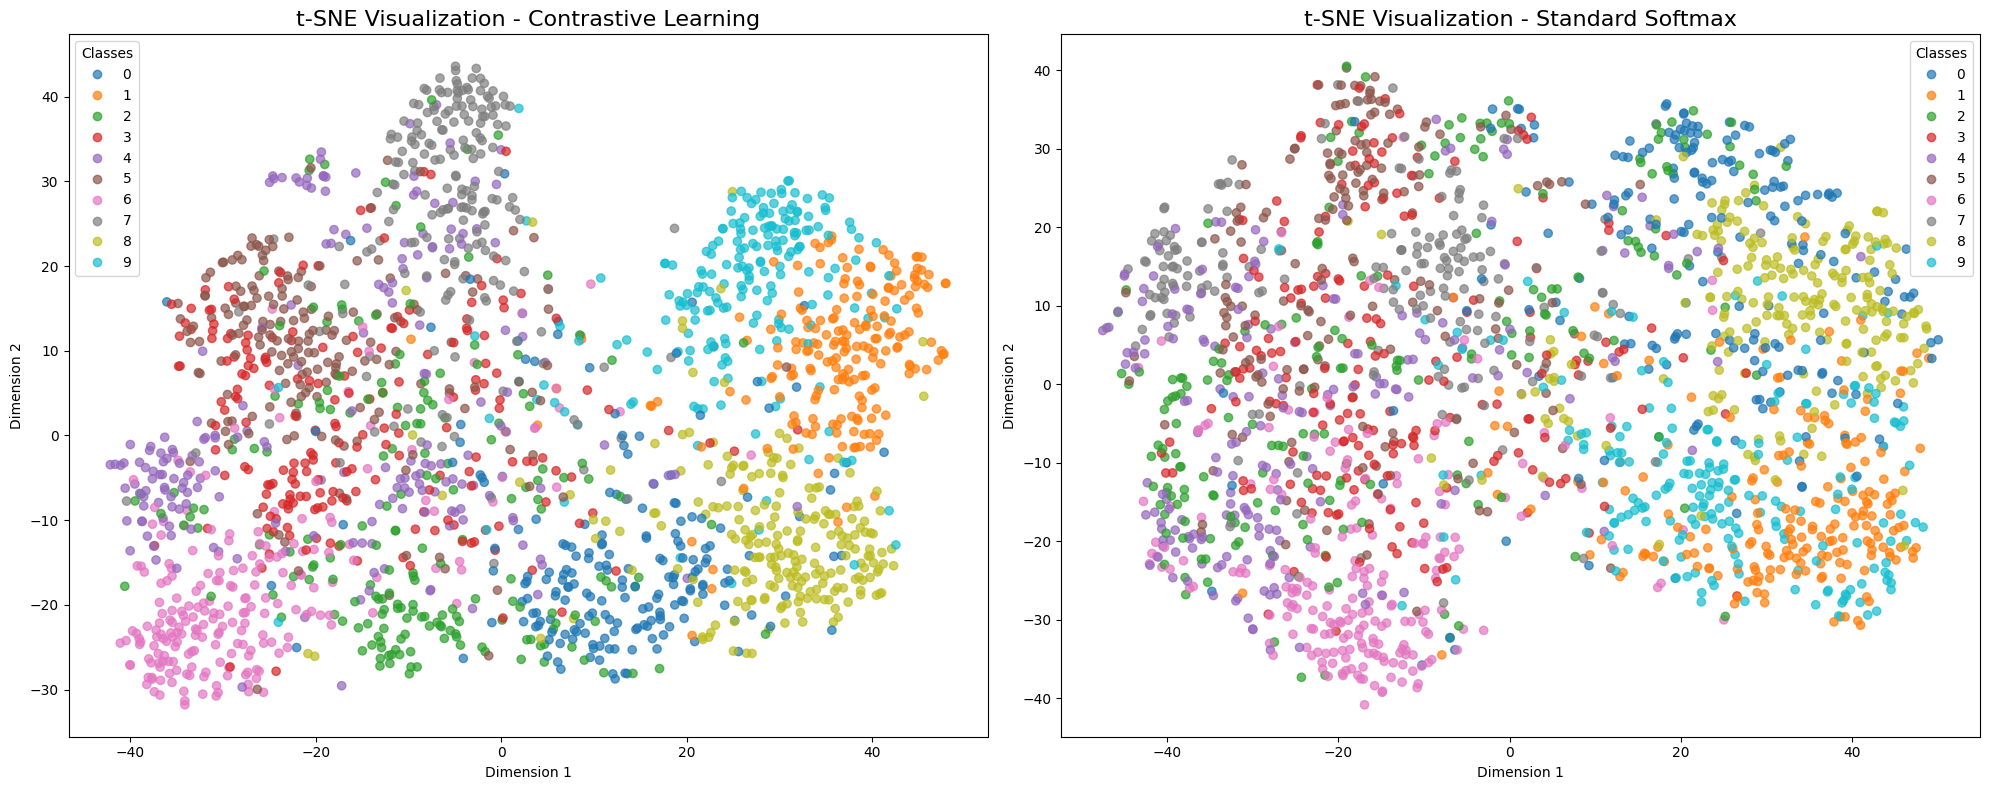

In [11]:
# Plot t-SNE visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot contrastive embeddings
scatter1 = ax1.scatter(embeddings_contrastive_2d[:, 0], embeddings_contrastive_2d[:, 1],
                       c=y_test[:2000], cmap='tab10', alpha=0.7)
ax1.set_title("t-SNE Visualization - Contrastive Learning", fontsize=16)
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
ax1.legend(*scatter1.legend_elements(), title="Classes", loc="best")

# Plot softmax embeddings
scatter2 = ax2.scatter(embeddings_softmax_2d[:, 0], embeddings_softmax_2d[:, 1],
                       c=y_test[:2000], cmap='tab10', alpha=0.7)
ax2.set_title("t-SNE Visualization - Standard Softmax", fontsize=16)
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
ax2.legend(*scatter2.legend_elements(), title="Classes", loc="best")

plt.tight_layout()
plt.show()